# Optimal UTXO size for difficulty and static reward

Quickly find the optimal Peercoin UTXO size for a given difficulty and static reward. Parameters can be adjusted for the displayed chart.

This uses daily probabilities as an approximation for per-second probabilities. It also assumes minting occurs continuously.

Determines the probability distribution for mints across multiple days and then finds a geometric average reward weighted by these probabilities.

Produced by MattLM with credit to Nagalim for ideas and alternative solutions.

Tips are welcome: PTuwboaoow7XF7Vrr68oremimo9wgrvxQ6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6.0, 5.0]

## Parameters

In [2]:
MAX_DAYS = 365*2
MIN_PROB_DAYS=30
RAMP_UP = 60
RELATIVE_REWARD = 0.03

In [3]:
DIFF = 17.40
STATIC_REWARD = 1.34
EXAMPLE_SIZE = 80

## Helpful constants

In [4]:
SECDAY=60*60*24
DAYYEAR=(365*33+8)/33
# Offset days by 0.5 to assume mint occurs somewhere in middle of day
DAYS = [MIN_PROB_DAYS+x+0.5 for x in range(MAX_DAYS)]
DAYS_WITH_NO_MINT = DAYS + [MAX_DAYS+MIN_PROB_DAYS]

## Calculate daily probability distribution

Includes the rampup

In [5]:
# 60.5/(RAMP_UP+0.5) normalises so that the end probability is always the same
# Offset by 0.5 to assume middle of day
probSecs = np.array([2**224 * (min(x, RAMP_UP)+0.5) * (60.5/(RAMP_UP+0.5)) / (2**256) for x in range(MAX_DAYS)])

def generateDailyProbs(outValue, diff):
    
    adj = outValue / diff

    # Independent probabilities
    failDayProbs = (1 - probSecs*adj)**SECDAY
    mintDayProbs = 1 - failDayProbs

    # Actual probability of mint on day assuming no mints before
    cumFail = failDayProbs.cumprod()
    # Prob of fail up-to now
    cumPrevFail = np.insert(cumFail, 0, 1)[:MAX_DAYS]
    # Prob of fail up-to now and success now gives chance of mint on this day
    # Add probabilty of final day to represent no successful mints
    return np.append(cumPrevFail*mintDayProbs, cumFail[-1])
        

In [6]:
dayProbs = generateDailyProbs(EXAMPLE_SIZE, DIFF)

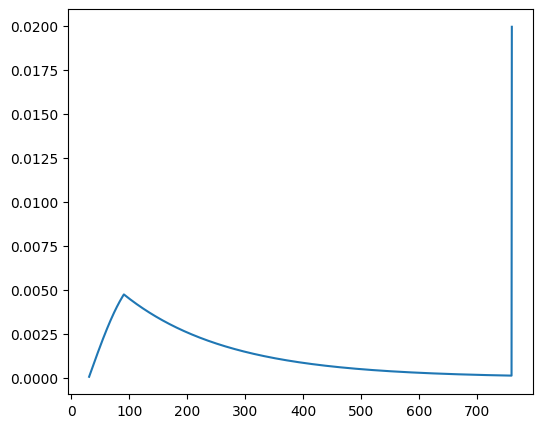

In [7]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs)
plt.show()

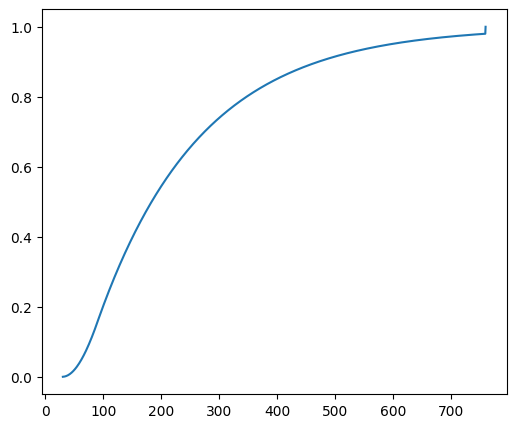

In [8]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs.cumsum())
plt.show()

In [9]:
# Should add up to 1
dayProbs.sum()

1.0

## Calculate Geometric average of rewards weighted by probabilities

In [10]:
def dailyRewards(outValue, staticReward):
    mintRewards = np.fromiter((outValue*RELATIVE_REWARD*min(365, x)/DAYYEAR + staticReward for x in DAYS), dtype=float)
    includingFailed = np.append(mintRewards, 0)
    return includingFailed

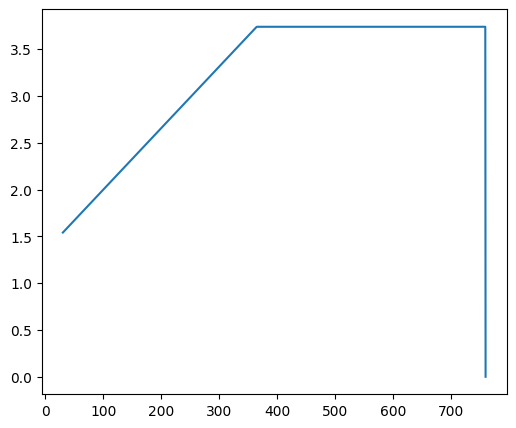

In [11]:
rewards = dailyRewards(EXAMPLE_SIZE, STATIC_REWARD)
plt.plot(DAYS_WITH_NO_MINT, rewards)
plt.show()

In [12]:
def averageReward(outValue, diff, staticReward):
    probs = generateDailyProbs(outValue, diff)
    rewards = dailyRewards(outValue, staticReward)
    returns = 1+rewards/outValue
    
    weightedReturn = (returns**probs).prod()
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()
    return (weightedReturn**(DAYYEAR/weightedTime) - 1) * 100

In [13]:
averageReward(EXAMPLE_SIZE, DIFF, STATIC_REWARD)

5.132175411965534

## Plot UTXO sizes

In [14]:
sizes = [10**(x/125) for x in range(500)]

In [15]:
rewardForSizes = np.fromiter((averageReward(x, DIFF, STATIC_REWARD) for x in sizes), dtype=float)

In [16]:
def addFigText(optimal):
    plt.figtext(0.5, -0.03, f"Additional parameters: percentage reward={RELATIVE_REWARD*100}%, min days={MIN_PROB_DAYS}, ramp days={RAMP_UP}, max days={MAX_DAYS}", ha="center", fontsize=10)
    plt.figtext(0.5, -0.08, f"Optimal UTXO Size: {optimal:.6f} PPC", ha="center", fontsize=10)

In [17]:
def plotResults(results, yLabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, results)
    ax.set_xlabel("UTXO Size")
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    addFigText(sizes[results.argmax()])
    plt.xscale("log")
    plt.grid(which="both")
    plt.show()

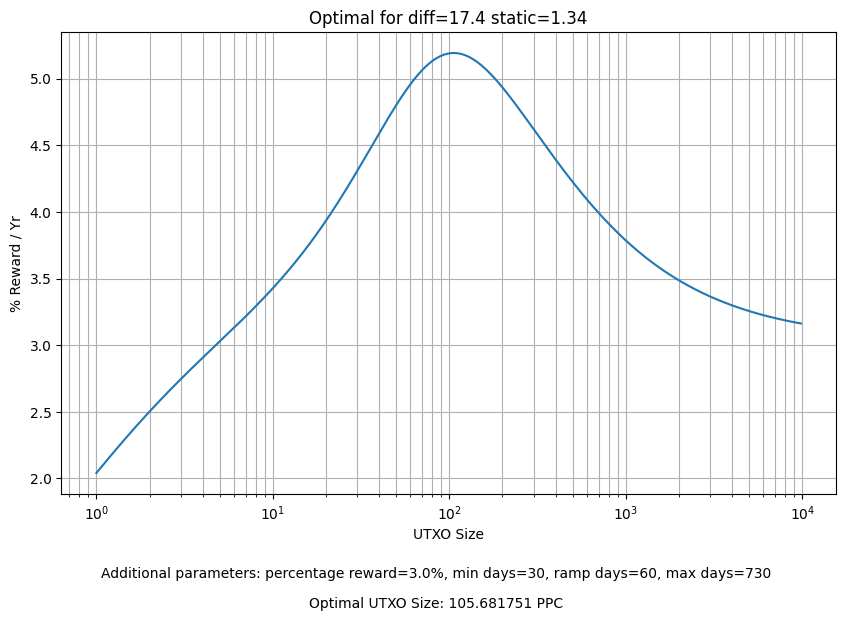

In [18]:
plotResults(rewardForSizes, "% Reward / Yr", f"Optimal for diff={DIFF} static={STATIC_REWARD}")

## Number of Mints

In [19]:
def averageMints(outValue, diff):
    probs = generateDailyProbs(outValue, diff)
    probFail = probs[-1]
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()
    return (1-probFail)/weightedTime/outValue*365

In [20]:
mintsForSizes = np.fromiter((averageMints(x, DIFF) for x in sizes), dtype=float)

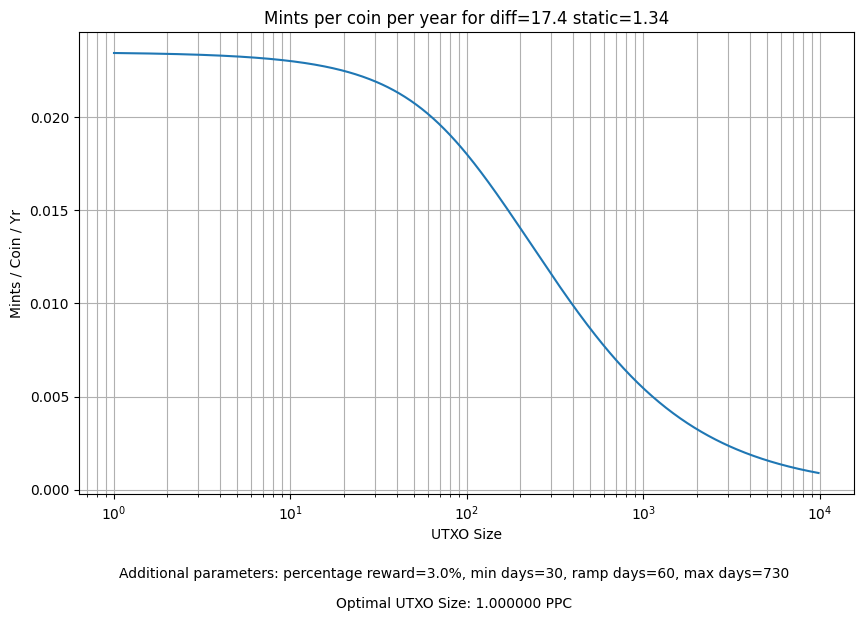

In [21]:
plotResults(mintsForSizes, "Mints / Coin / Yr", f"Mints per coin per year for diff={DIFF} static={STATIC_REWARD}")

## Combined Chart

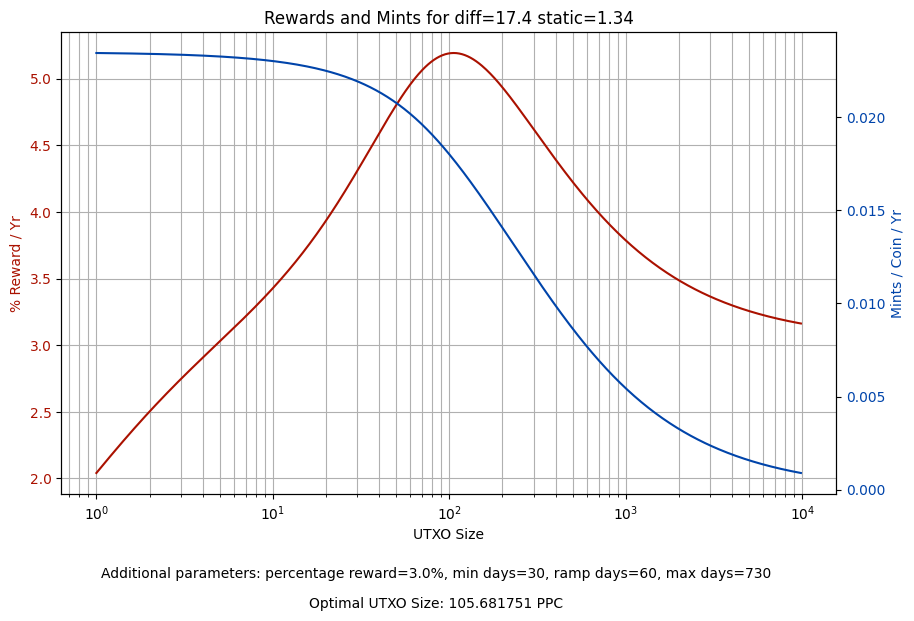

In [22]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Rewards and Mints for diff={DIFF} static={STATIC_REWARD}")
rewardAx.set_xlabel("UTXO Size")

colour = "#A10"
rewardAx.plot(sizes, rewardForSizes, color=colour)
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

mintsAx = rewardAx.twinx()
colour = "#04A"
mintsAx.plot(sizes, mintsForSizes, color=colour)
mintsAx.tick_params(axis ='y', labelcolor=colour) 
mintsAx.set_ylabel("Mints / Coin / Yr", color=colour)

addFigText(sizes[rewardForSizes.argmax()])
plt.xscale("log")
rewardAx.grid(which="both")
plt.show()

### Loss of # mints at reward optimum

In [23]:
f"-{(1 - mintsForSizes[rewardForSizes.argmax()] / mintsForSizes.max())*100:.2f}%"

'-24.42%'

## Optimal UTXO Size

In [24]:
# UTXO Size
maxI = rewardForSizes.argmax()
sizes[maxI]

105.68175092136585

In [25]:
# Reward
maxReward = rewardForSizes.max()
maxReward

5.192584244052911

In [26]:
def findWithinTolerance(it, tolerance):
    for i in it:
        if (maxReward - rewardForSizes[i] > tolerance):
            return sizes[i+1]

In [27]:
# -10bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.1)

74.47319739059893

In [28]:
# -10bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.1)

158.48931924611142

In [29]:
# -20bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.2)

63.09573444801933

In [30]:
# -20bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.2)

187.06821403657997